## Introdução

O presente notebook aborda o problema de **detecção de fraudes em transações financeiras**. Cada linha da base representa uma transação feita com cartão de crédito, contendo informações como data, valor, localização, estabelecimento, e um campo binário (`is_fraud`) que indica se a transação foi fraudulenta ou não.

Para a tarefa de classificação, foi utilizado uma abordagem híbrida dos algoritmos **Random Forest** e **Isolation Forest**.


## Bibliotecas Utilizadas

| Biblioteca / Módulo                        | Descrição                                                                 |
|-------------------------------------------|---------------------------------------------------------------------------|
| `pandas` (`pd`)                           | Utilizada para manipulação e análise de dados em forma de tabelas (DataFrames). |
| `sklearn.model_selection.train_test_split` | Função para dividir o conjunto de dados em treino e teste.                |
| `sklearn.preprocessing.OneHotEncoder`     | Codifica variáveis categóricas em vetores binários (one-hot encoding).    |
| `sklearn.compose.ColumnTransformer`       | Permite aplicar diferentes transformações a diferentes colunas do DataFrame. |
| `sklearn.pipeline.Pipeline`               | Cria um fluxo de processamento com etapas sequenciais (ex: pré-processamento + modelo). |
| `sklearn.ensemble.RandomForestClassifier` | Algoritmo de aprendizado de máquina baseado em múltiplas árvores de decisão para classificação. |
| `sklearn.ensemble.IsolationForest`        | Algoritmo para detecção de anomalias baseado em árvores (unsupervised).   |
| `numpy` (`np`)                            | Biblioteca para computação numérica e manipulação de arrays.              |
| `sklearn.metrics.*`                       | Conjunto de funções para avaliação de modelos (ex: accuracy, F1, ROC AUC, etc.). |
| `matplotlib.pyplot` (`plt`)               | Biblioteca para criação de gráficos e visualizações.                      |


In [27]:
# Manipulação de dados
import numpy as np
import pandas as pd

# Pré-processamento e transformação
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
# Modelos
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.pipeline import Pipeline
# Divisão dos dados
from sklearn.model_selection import train_test_split
# Métricas de avaliação
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)
# Visualização opcional (se quiser ver distribuição dos scores)
import matplotlib.pyplot as plt
import seaborn as sns

# ignora warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Descrição das Colunas da Base de Dados

| Coluna                 | Descrição                                                                 |
|------------------------|---------------------------------------------------------------------------|
| `Unnamed: 0`           | Índice original do dataset                                                |
| `trans_date_trans_time` | Data e hora da transação.                                                |
| `cc_num`               | Número do cartão de crédito (anonimizado).                                |
| `merchant`             | Nome do comerciante onde a transação ocorreu.                             |
| `category`             | Categoria do comerciante (ex: food, gas_transport, etc).                  |
| `amt`                  | Valor da transação em dólares.                                            |
| `first`                | Primeiro nome do titular do cartão.                                       |
| `last`                 | Sobrenome do titular do cartão.                                           |
| `gender`               | Gênero do titular do cartão (`M` ou `F`).                                 |
| `street`               | Endereço residencial do titular do cartão.                                |
| `lat`                  | Latitude da residência do titular do cartão.                              |
| `long`                 | Longitude da residência do titular do cartão.                             |
| `city_pop`             | População estimada da cidade de residência.                               |
| `job`                  | Profissão do titular do cartão.                                           |
| `dob`                  | Data de nascimento do titular do cartão.                                  |
| `trans_num`            | Identificador único da transação.                                         |
| `unix_time`            | Timestamp UNIX da transação.                                              |
| `merch_lat`            | Latitude do comerciante.                                                  |
| `merch_long`           | Longitude do comerciante.                                                 |
| `is_fraud`             | Indicador de fraude (`1` para fraude, `0` para legítima).                 |


In [2]:
# Importação e visualização das colunas
dataframe = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
dataframe.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [4]:
# verificando a contagem de dados faltantes
dataframe.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [5]:
# verificando a quantidade de dados únicos por coluna
dataframe.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64

## Organização de dados relevantes

1. Transformar datas em  conjuntos de objetos em formato datetime.
2. Organização de transações por cartões, em seguida, calcula a diferença de tempo entre cada transação.
3. Remove colunas irrelevantes, definir coluna de label `is_fraud`, e remover a coluna label dos dados que serão usados no treinamento.
4. Categorizando colunas em classes `Numéricas` e `Categóricas`.
5. Aplicação do One-Hot encoding para as features categóricas.

### Separação de Variáveis: `X` e `y`

| Variável | Conteúdo                              | Função no Modelo                                |
|----------|----------------------------------------|--------------------------------------------------|
| `X`      | Todas as colunas **independentes** do DataFrame (features), exceto a variável alvo (`target_col`). | Usada como entrada para o treinamento e predição. |
| `y`      | Coluna **alvo** (`target_col`) do DataFrame, contendo os rótulos (ex: `is_fraud`). | Usada como saída esperada no treinamento (o que o modelo tenta prever). |


In [6]:
# Datas para Objetos Datetimes
dataframe['trans_date_trans_time'] = pd.to_datetime(dataframe['trans_date_trans_time'])
dataframe['hour_of_day'] = dataframe['trans_date_trans_time'].dt.hour
dataframe['day_of_week'] = dataframe['trans_date_trans_time'].dt.dayofweek
dataframe['month'] = dataframe['trans_date_trans_time'].dt.month

In [7]:
# Diferença de tempo entre transações.
dataframe = dataframe.sort_values(by=['cc_num', 'trans_date_trans_time'])
dataframe['time_since_last_transaction'] = dataframe.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds().fillna(0)

In [8]:
# Definir coluna label
target_col = 'is_fraud'
# Removendo colunas irrelevantes e coluna label dos dados de treinamento
columns_to_drop_final = ['Unnamed: 0', 'trans_num', 'first', 'last', 'street', 'city', 'zip', 'dob', 'ssn']
df_processed = dataframe.drop(columns=columns_to_drop_final, errors='ignore').copy()

In [9]:
df_processed

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,hour_of_day,day_of_week,month,time_since_last_transaction
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,F,WY,43.0048,-108.8964,1645,Information systems manager,1325422035,43.974711,-109.741904,0,12,1,1,0.0
2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,F,WY,43.0048,-108.8964,1645,Information systems manager,1325493897,42.018766,-109.044172,0,8,2,1,71862.0
2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,F,WY,43.0048,-108.8964,1645,Information systems manager,1325494056,42.961335,-109.157564,0,8,2,1,159.0
2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,F,WY,43.0048,-108.8964,1645,Information systems manager,1325507894,42.228227,-108.747683,0,12,2,1,13838.0
2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,F,WY,43.0048,-108.8964,1645,Information systems manager,1325509846,43.321745,-108.091143,0,13,2,1,1952.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294934,2020-06-20 21:04:59,4992346398065154184,"fraud_Berge, Kautzer and Harris",personal_care,60.47,M,IL,41.1730,-89.2187,532,Audiological scientist,1371762299,40.475395,-89.076105,0,21,5,6,30740.0
1295369,2020-06-21 00:41:01,4992346398065154184,fraud_Bernhard Inc,gas_transport,74.29,M,IL,41.1730,-89.2187,532,Audiological scientist,1371775261,40.743634,-89.553379,0,0,6,6,12962.0
1295587,2020-06-21 02:47:59,4992346398065154184,"fraud_Reichert, Rowe and Mraz",shopping_net,246.56,M,IL,41.1730,-89.2187,532,Audiological scientist,1371782879,40.215418,-88.682562,0,2,6,6,7618.0
1296206,2020-06-21 08:04:28,4992346398065154184,fraud_Jewess LLC,shopping_pos,2.62,M,IL,41.1730,-89.2187,532,Audiological scientist,1371801868,40.762861,-88.744967,0,8,6,6,18989.0


In [10]:
X = df_processed.drop(columns=[target_col], errors='ignore')
y = df_processed[target_col]
# Categorização de colunas
numerical_cols = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'time_since_last_transaction', 'merch_lat', 'merch_long']
categorical_cols = ['category', 'gender', 'state', 'job', 'merchant']

## Análise Exploratória dos Dados

Por meio da análise exploratória dos dados, visa-se identificar tendências e característica dos dados

Distribuição percentual:
is_fraud
0    99.421135
1     0.578865
Name: count, dtype: float64


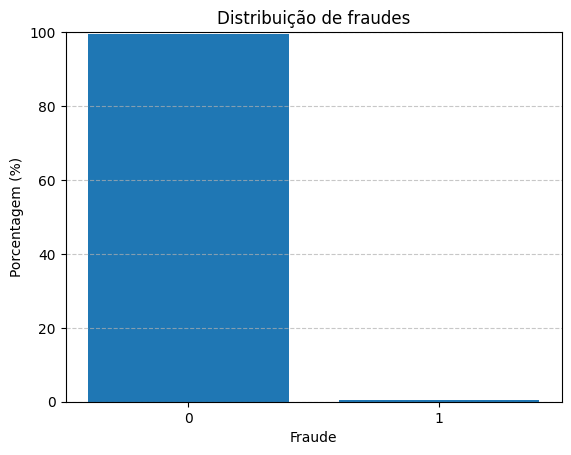

In [11]:
# distribuição da variável is_fraud (target)
counts = df_processed['is_fraud'].value_counts().sort_index()

# calcula porcentagem da distribuição
percentages = counts / counts.sum() * 100

print("Distribuição percentual:")
print(percentages)

# plota histogram
plt.bar(counts.index.astype(str), percentages)
plt.xlabel('Fraude')
plt.ylabel('Porcentagem (%)')
plt.title('Distribuição de fraudes')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
# https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset#3.4-Data-imbalance-check
from collections import Counter

def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('A quantidade total de outliers detectados é de:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [13]:
# detectando outliers
Outliers_IQR = IQR_method(dataframe,1, numerical_cols)

# coletando outliers
outliers = dataframe.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

A quantidade total de outliers detectados é de: 41994


## Analisando Relações entre as Features

Para esta análise, será adotada a métrica de informação mútua(mutual information). Diferentemente da correlação, esta métrica é capaz de detectar qualquer tipo de relação entre as features, além de apenas as relações lineares. No entanto, a implementação do cálculo da mutual information pelo scikit-learn é aceita apenas variáveis discretas ou contínuas.

Referência: [Mutual Information](https://www.kaggle.com/code/ryanholbrook/mutual-information)

In [14]:
from sklearn.preprocessing import OrdinalEncoder

X.drop(columns=["trans_date_trans_time"], inplace=True)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-1)

# Label encoding para variaveis categoricas
for colname in categorical_cols:
    X[[colname]] = encoder.fit_transform(X[[colname]])

# discrete_features = X.dtypes == int

In [15]:
# from sklearn.feature_selection import mutual_info_regression

# # cria os scores de informacao mutua
# def make_mi_scores(X, y, discrete_features):
#     mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# mi_scores = make_mi_scores(X_copy, y_copy, discrete_features)
# mi_scores[::3]

In [16]:
# def plot_mi_scores(scores):
#     scores = scores.sort_values(ascending=True)
#     width = np.arange(len(scores))
#     ticks = list(scores.index)
#     plt.barh(width, scores)
#     plt.yticks(width, ticks)
#     plt.title("Mutual Information Scores")


# plt.figure(dpi=100, figsize=(8, 5))
# plot_mi_scores(mi_scores)"

## Treinamento

1. Pré-Processamento de dados para o modelo usar de forma eficiente as classes `numéricas` e `categóricas`
2. Separação de treino e testes. Neste caso, foi utilizado 80% dos dados para testes e 20% para validações do modelo.
3. Filtragem de dados com Isolation Forest.
5. Treinamento do modelo utilizando o modelo Random Forest com os dados pré-filtrados pelo IF.

In [17]:
# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [31]:
print(X_train.shape)
print(X_test.shape)

(1037340, 17)
(259335, 17)


## Desbalanceamento dos Dados e Cross-validation

A fim de mitigar o desbalanceamento dos dados, serão testadas e comparadas três abordagens de balanceamento de dados, uma com oversampling, outra com undersampling e uma abordagem usando geração sintética de dados da classe minoritária por meio da técnica SMOTE.

Para evitar o vazamento de dados("data leakage"), é necessário que o balanceamento seja feito apenas após a validação cruzada, ou cross-validation. 

In [18]:
# from sklearn.model_selection import StratifiedKFold

# def kfold(X, y):
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 	# faz o split
# 	train_X, test_X = X[train_ix], X[test_ix]
# 	train_y, test_y = y[train_ix], y[test_ix]
# 	train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
# 	test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
# 	print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

In [24]:
# função que aplica a isolation forest + random forest
def isolate_predict(X_train, y_train, X_test, y_test):
    # Pré-filtragem com Isolation Forest
    iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
    iso.fit(X_train)
    
    # Aplicar no conjunto de teste
    anomaly_scores = -iso.decision_function(X_test)
    
    # Selecionar apenas os mais anômalos
    threshold = np.percentile(anomaly_scores, 95)
    mask_suspects = anomaly_scores >= threshold
    
    # Filtrar para Random Forest
    X_test_suspects = X_test[mask_suspects]
    y_test_suspects = y_test[mask_suspects]
    
    # Treinar Random Forest no conjunto completo (poderia ser refinado também)
    rf_clf = RandomForestClassifier(
                n_estimators=100, 
                random_state=42, 
                n_jobs=-1, 
                class_weight='balanced'
            )
    
    rf_clf.fit(X_train, y_train)
    
    # Aplicar RF apenas nos casos suspeitos
    rf_predictions = rf_clf.predict(X_test_suspects)
    rf_probabilities = rf_clf.predict_proba(X_test_suspects)[:, 1]

    # Avaliação
    print("\nAvaliação apenas nos casos suspeitos (filtrados pelo Isolation Forest):")
    print(classification_report(y_test_suspects, rf_predictions, target_names=['Não Fraude', 'Fraude']))
    
    f1 = f1_score(y_test_suspects, rf_predictions, pos_label=1)
    precision = precision_score(y_test_suspects, rf_predictions, pos_label=1)
    recall = recall_score(y_test_suspects, rf_predictions, pos_label=1)

    print(f"F1-Score (Fraude): {f1:.4f}")
    print(f"Recall (Fraude): {recall:.4f}")
    print(f"Precisão (Fraude): {precision:.4f}")

    # evaluate pipeline
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
    # score = mean(scores)
    # print('F1 Score: %.3f' % score)

### Oversampling

In [20]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
# fit e aplica a transformacao
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print('Feature/label dataset de treinamento antes do RandomOverSampler: ', X_train.shape, y_train.shape)
print('Feature/label dataset de treinamento após o RandomOverSampler: ', X_train_ros.shape, y_train_ros.shape)
print('nova distribuição após a aplicação do RandomOverSampler: \n', pd.Series(y_train_ros).value_counts())

Feature/label dataset de treinamento antes do RandomOverSampler:  (1037340, 17) (1037340,)
Feature/label dataset de treinamento após o RandomOverSampler:  (2062670, 17) (2062670,)
nova distribuição após a aplicação do RandomOverSampler: 
 is_fraud
0    1031335
1    1031335
Name: count, dtype: int64


In [25]:
isolate_predict(X_train_ros, y_train_ros, X_test, y_test)


Avaliação apenas nos casos suspeitos (filtrados pelo Isolation Forest):
              precision    recall  f1-score   support

  Não Fraude       1.00      1.00      1.00     12854
      Fraude       0.91      0.76      0.83       113

    accuracy                           1.00     12967
   macro avg       0.96      0.88      0.91     12967
weighted avg       1.00      1.00      1.00     12967

F1-Score (Fraude): 0.8309
Recall (Fraude): 0.7611
Precisão (Fraude): 0.9149


### Undersampling

In [28]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)
# fit e aplica a transformacao
X_train_rus, y_train_rus = ros.fit_resample(X_train, y_train)

print('Feature/label dataset de treinamento antes do Undersampling: ', X_train.shape, y_train.shape)
print('Feature/label dataset de treinamento após o Undersampling: ', X_train_rus.shape, y_train_rus.shape)
print('nova distribuição após a aplicação do Undersampling: \n', pd.Series(y_train_rus).value_counts())

Feature/label dataset de treinamento antes do Undersampling:  (1037340, 17) (1037340,)
Feature/label dataset de treinamento após o Undersampling:  (12010, 17) (12010,)
nova distribuição após a aplicação do Undersampling: 
 is_fraud
0    6005
1    6005
Name: count, dtype: int64


In [32]:
isolate_predict(X_train_rus, y_train_rus, X_test, y_test)


Avaliação apenas nos casos suspeitos (filtrados pelo Isolation Forest):
              precision    recall  f1-score   support

  Não Fraude       1.00      0.96      0.98     12860
      Fraude       0.16      0.96      0.27       107

    accuracy                           0.96     12967
   macro avg       0.58      0.96      0.62     12967
weighted avg       0.99      0.96      0.97     12967

F1-Score (Fraude): 0.2696
Recall (Fraude): 0.9626
Precisão (Fraude): 0.1568
